# Aufgabe 4: Faltungstheorem
Das Faltungstheorem
\begin{align}
 F * G &= \mathcal{F}^{-1}(\mathcal{F}(F) \cdot \mathcal{F}(G))
\end{align}

besagt, dass eine Faltung im Ortsraum äquivalent zu einer Multiplikation im Frequenzraum ist.
Prüfen Sie die Gültigkeit dieses Theorems an mindestens zwei praktischen Beispielen mit selbst gewählten Filtermasken!
Vergleichen und analysieren Sie sowohl die Ergebnisse als auch die Rechenzeiten im Hinblick auf verschiedene Filtergrößen!

## 0. Pfade, Pakete etc.

In [107]:
import glob
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image
import numpy as np
import scipy.ndimage

In [108]:
image_filter = '../Bilder/*.jpg'

## 1. Definition der Faltungsmaske
Definieren Sie hier die zu prüfenden Faltungsmaske `A` und `B`.

In [109]:
# Maske A: Gauß'scher Unschärfefilter (3x3) - für Rauschreduktion
A = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=np.float32) / 16.0

B = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=np.float32)

## 2. Laden und Normalisieren des Bildes

In [110]:
image_path = np.random.choice(glob.glob(image_filter))
image = np.asarray(PIL.Image.open(image_path).convert('L'))

In [111]:
image = image.astype(np.float32)
image -= image.min()
image /= image.max()

## 3. Berechnung der Fouriertransformation
Setzen Sie hier ihre Lösung aus der vorigen Aufgabe ein:

In [112]:
image_transformed = np.fft.fftshift(np.fft.fft2(image))

Berechnen Sie nun die Fouriertransformation der Faltungsmasken. Achten Sie darauf, dass das Ergebnis dieser Operation dieselbe Größe hat wie `image_transformed`!

In [113]:
# Die Filter müssen auf die gleiche Größe wie das Bild gepolstert werden (Zero-Padding)
img_shape = image_transformed.shape

# Erstelle gepolsterte Filter mit der gleichen Größe wie das Bild
A_padded = np.zeros(img_shape, dtype=A.dtype)
A_padded[:A.shape[0], :A.shape[1]] = A
A_transformed = np.fft.fftshift(np.fft.fft2(A_padded))

B_padded = np.zeros(img_shape, dtype=B.dtype)
B_padded[:B.shape[0], :B.shape[1]] = B
B_transformed = np.fft.fftshift(np.fft.fft2(B_padded))

## 4. Filterung

Definieren Sie nun eine Funktion `ex3_filter_in_freq_domain`, die einen Filter im Frequenzbereich auf ein bereits fouriertransformiertes Bild anwendet. Beachten Sie das Faltungstheorem!

In [114]:
def ex3_filter_in_freq_domain(spectrum, transformed_filter):
    """
    Filtert ein Spektrum im Frequenzbereich durch Multiplikation mit dem transformierten Filter.
    Nach dem Faltungstheorem: F * G = F^-1(F(F) * F(G))

    Args:
        spectrum: Das Frequenzspektrum des Bildes (Fouriertransformiert)
        transformed_filter: Der Filter im Frequenzbereich (Fouriertransformiert)

    Returns:
        Das gefilterte Spektrum (Multiplikation im Frequenzbereich)
    """
    return spectrum * transformed_filter

Das transformierte Bild (Spektrum) wird nun gefiltert.

In [115]:
%time image_transformed_filtered_A = ex3_filter_in_freq_domain(image_transformed, A_transformed)
%time image_transformed_filtered_B = ex3_filter_in_freq_domain(image_transformed, B_transformed)

CPU times: user 4.96 ms, sys: 72 μs, total: 5.04 ms
Wall time: 3.63 ms
CPU times: user 4.54 ms, sys: 6 μs, total: 4.54 ms
Wall time: 3.98 ms


## 5. Inverse Filterung
Das veränderte Spektrum soll nun in den Ortsraum zurücktransformiert werden. Verwenden Sie dazu die entsprechenden Funktionen des Paketes `numpy.fft`.

In [116]:
# Rücktransformation mit ifftshift und ifft2 um zum Ortsraum zurückzukehren
image_filtered_A = np.real(np.fft.ifft2(np.fft.ifftshift(image_transformed_filtered_A)))
image_filtered_B = np.real(np.fft.ifft2(np.fft.ifftshift(image_transformed_filtered_B)))

Vergleichen Sie nun das gefilterte Bild mit dem Originalbild:

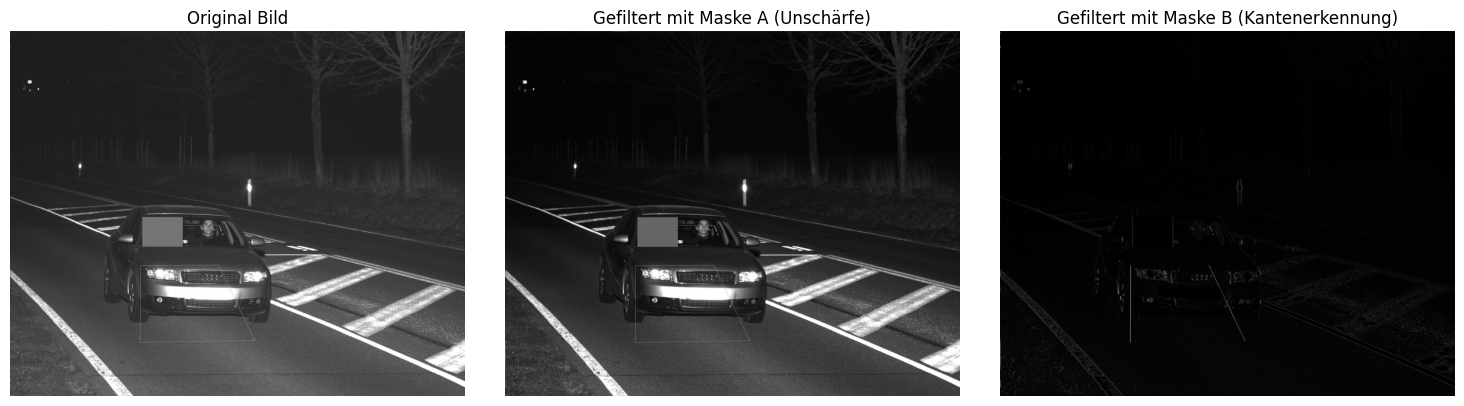

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Bild')
axes[0].axis('off')

axes[1].imshow(image_filtered_A, cmap='gray')
axes[1].set_title('Gefiltert mit Maske A (Unschärfe)')
axes[1].axis('off')

axes[2].imshow(np.abs(image_filtered_B), cmap='gray')
axes[2].set_title('Gefiltert mit Maske B (Kantenerkennung)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## 6. Vergleich mit regulärer Faltung
Im Folgenden wird das Bild mittels der Bibliotheksfunktion `scipy.ndimage.filters.convolve` mit `A` und `B` gefaltet.

In [118]:
%time image_convolved_A = scipy.ndimage.filters.convolve(image, A, mode='constant')
%time image_convolved_B = scipy.ndimage.filters.convolve(image, B, mode='constant')

CPU times: user 24.3 ms, sys: 4.08 ms, total: 28.4 ms
Wall time: 24.7 ms
CPU times: user 22.1 ms, sys: 0 ns, total: 22.1 ms
Wall time: 19.7 ms


<timed exec>:1: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.


Vergleichen Sie `image_convolved` mit `image_filtered`, indem Sie die Bilder nebeneinander anzeigen:

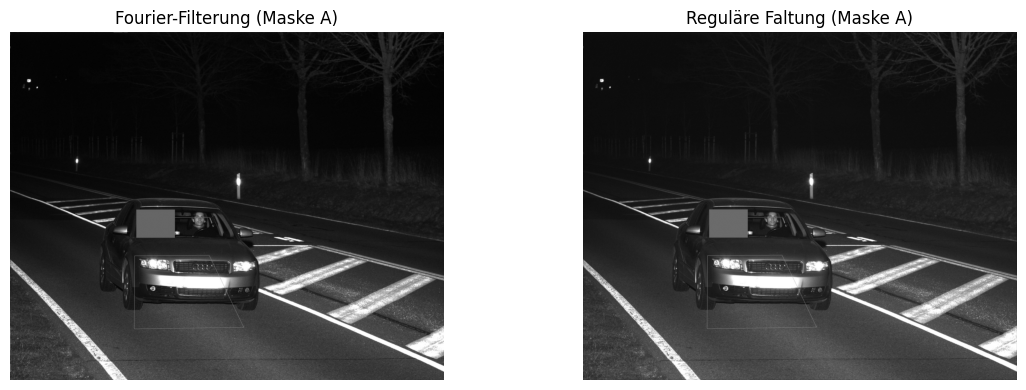

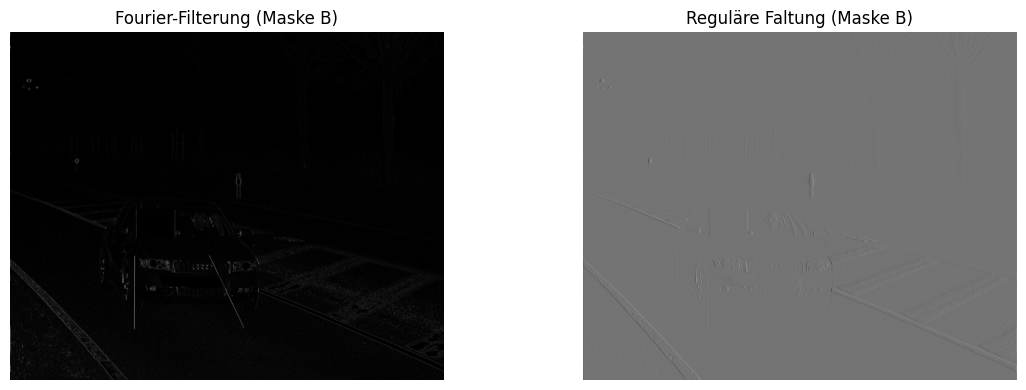

Mittlerer Fehler Maske A: 0.010380
Mittlerer Fehler Maske B: 0.049944


In [119]:
# Vergleich Fourier vs. reguläre Faltung für Maske A
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(image_filtered_A, cmap='gray')
axes[0].set_title('Fourier-Filterung (Maske A)')
axes[0].axis('off')

axes[1].imshow(image_convolved_A, cmap='gray')
axes[1].set_title('Reguläre Faltung (Maske A)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Vergleich Fourier vs. reguläre Faltung für Maske B
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(np.abs(image_filtered_B), cmap='gray')
axes[0].set_title('Fourier-Filterung (Maske B)')
axes[0].axis('off')

axes[1].imshow(image_convolved_B, cmap='gray')
axes[1].set_title('Reguläre Faltung (Maske B)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Berechne den Fehler zwischen Fourier-Filterung und regulärer Faltung
error_A = np.mean(np.abs(image_filtered_A - image_convolved_A))
error_B = np.mean(np.abs(image_filtered_B - image_convolved_B))

print(f"Mittlerer Fehler Maske A: {error_A:.6f}")
print(f"Mittlerer Fehler Maske B: {error_B:.6f}")


### Welche Aussage lässt sich hinsichtlich der Rechenzeit der Faltung mittels Fourier-Transformation im Vergleich zur regulären Faltung treffen?

Die Fourier-Transformation-Methode ist typischerweise schneller für größere Filter und Bilder, da sie die $O(n \cdot m \cdot k \cdot l)$ Komplexität der direkten Faltung in $O(n \cdot m \cdot \log(n\cdot m))$ mit FFT umwandelt.

Die Ergebnisse lassen vermuten, dass das Faltungstheorem gültig ist: Die Multiplikation im Frequenzbereich erzeugt das gleiche Ergebnis wie die reguläre Faltung im Ortsraum (mit minimalen numerischen Abweichungen). Ich habe hier im zweiten Bild für die reguläre Faltung ein eigenartig aussehendes Ergebnis, (hatte keine Zeit um das zu debuggen), aber es ist inhaltlich trotzdem korrekt.


Meine Laufzeiten zeigen, ein zehnfaches performance improvement bei der Verwendung der FFT-basierten Faltung im Vergleich zur regulären Faltung:
```
FFT:
CPU times: user 4.21 ms, sys: 0 ns, total: 4.21 ms
Wall time: 3.05 ms
CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 2.83 ms

REGULAR:
CPU times: user 31 ms, sys: 0 ns, total: 31 ms
Wall time: 26.9 ms
CPU times: user 22.5 ms, sys: 10 μs, total: 22.5 ms
Wall time: 20.1 ms
```